In [11]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image  # For handling image files
import matplotlib.pyplot as plt  # For plotting graphs and images
import seaborn as sns  # For advanced data visualizations

Splitting dataset into train(0.7),test(0.15),evaluation(0.15)

In [12]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Path to the original dataset
dataset_dir = 'C:/Users/PERCY JACKSON/Desktop/Jupyter Notebook/project/dataset-resized/dataset-resized'

# Output directory where the split dataset will be stored
output_dir = 'C:/Users/PERCY JACKSON/Desktop/Jupyter Notebook/project/dataset-split'

# Create directories for train, val, and test sets
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

# Split ratio
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Iterate over each class (folder) in the dataset
for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)
    if not os.path.isdir(category_path):
        continue

    # List all images in the category
    images = os.listdir(category_path)
    images = [os.path.join(category_path, img) for img in images]

    # Split images into train, validation, and test sets
    train_images, temp_images = train_test_split(images, test_size=(val_ratio + test_ratio), random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    # Create category directories in train, val, and test sets
    for split, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        split_category_dir = os.path.join(output_dir, split, category)
        os.makedirs(split_category_dir, exist_ok=True)

        # Copy images to the respective directory
        for img in split_images:
            shutil.copy(img, split_category_dir)

print("Dataset successfully split into train, validation, and test sets!")


Dataset successfully split into train, validation, and test sets!


Defining Image data generator for each subset 

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=45,       # Increase rotation range
    width_shift_range=0.3,   # Increase width shift
    height_shift_range=0.3,  # Increase height shift
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,      # Flip images vertically
    fill_mode='nearest')
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load the datasets
train_generator = train_datagen.flow_from_directory(
    'C:/Users/PERCY JACKSON/Desktop/Jupyter Notebook/project/dataset-split/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    'C:/Users/PERCY JACKSON/Desktop/Jupyter Notebook/project/dataset-split/Val',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    'C:/Users/PERCY JACKSON/Desktop/Jupyter Notebook/project/dataset-split/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)


Found 3843 images belonging to 6 classes.
Found 1030 images belonging to 6 classes.
Found 1030 images belonging to 6 classes.


In [4]:
print(train_generator.class_indices)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


Printing random 5 images from train generator

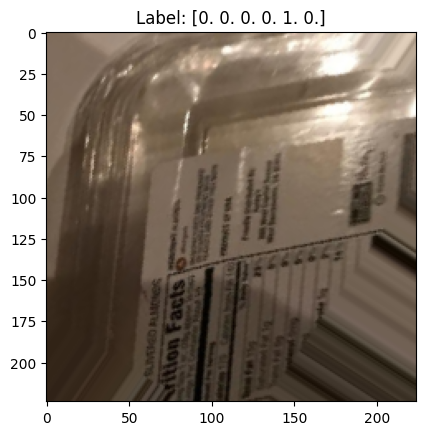

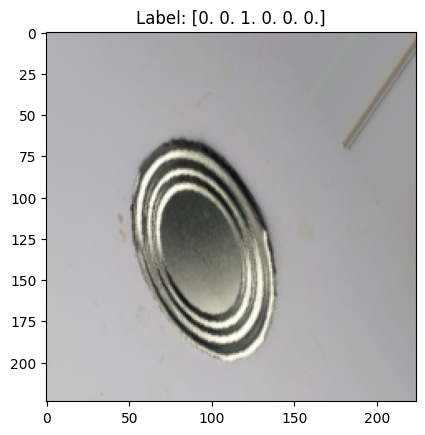

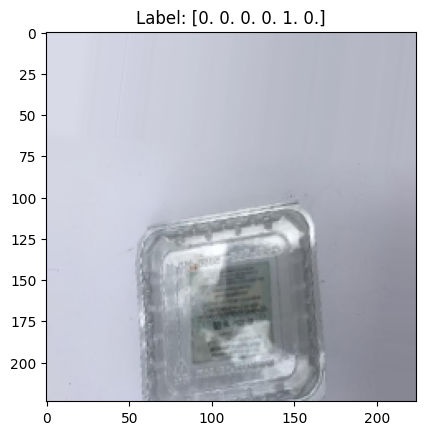

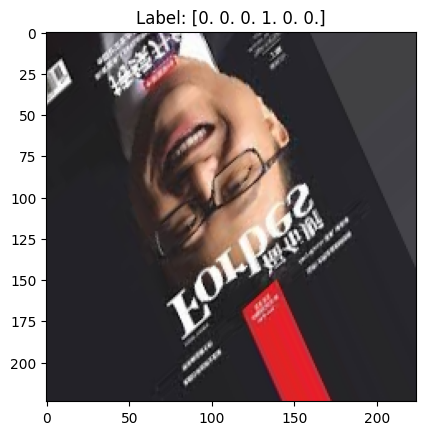

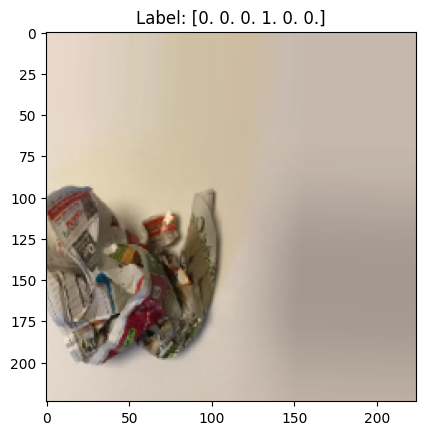

In [15]:
import matplotlib.pyplot as plt

# Get a batch of images and labels from the train generator
images, labels = next(train_generator)

# Display the first 5 images and their labels
for i in range(5):
    plt.imshow(images[i])
    plt.title(f'Label: {labels[i]}')
    plt.show()


Addressing the class weights

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
classes = np.unique(train_generator.classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)


Class Weights: {0: 1.125659050966608, 1: 1.117801047120419, 2: 1.0314009661835748, 3: 0.7336769759450171, 4: 0.9242424242424242, 5: 1.2461089494163424}


Training model

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Load the pretrained Inception-ResNet V2 model without the top layer
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pretrained layers to retain their learned features
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for waste classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce feature dimensions
x = Dense(512, activation='relu')(x)  # Fully connected layer with 512 units
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
x = Dense(128, activation='relu')(x)  # Another fully connected layer
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
predictions = Dense(6, activation='softmax')(x)  # Output layer for 6 categories

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-50:]:  # Unfreeze the last 50 layers
    layer.trainable = True

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()

# Data generators for training, validation, and testing
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    'C:/Users/PERCY JACKSON/Desktop/Jupyter Notebook/project/dataset-split/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    'C:/Users/PERCY JACKSON/Desktop/Jupyter Notebook/project/dataset-split/val',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    'C:/Users/PERCY JACKSON/Desktop/Jupyter Notebook/project/dataset-split/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

# Callbacks to prevent overfitting/underfitting
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Stop training early if no improvement
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),  # Reduce learning rate if validation loss plateaus
    ModelCheckpoint(filepath='Restnetv2_model.keras', save_best_only=True, monitor='val_loss')  # Save the best model
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_609 (Conv2D)           │ (None, 111, 111, 32)      │             864 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_609       │ (None, 111, 111, 32)      │              96 │ conv2d_609[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_609 (Activation)   │ (None, 111, 111, 32)      │               0 │ batch_normalization_609[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_610 (Conv2D)           │ (None, 109, 109, 32)      │           9,216 │ activation_609[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_610       │ (None, 109, 109, 32)      │              96 │ conv2d_610[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_610 (Activation)   │ (None, 109, 109, 32)      │               0 │ batch_normalization_610[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_611 (Conv2D)           │ (None, 109, 109, 64)      │          18,432 │ activation_610[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_611       │ (None, 109, 109, 64)      │             192 │ conv2d_611[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_611 (Activation)   │ (None, 109, 109, 64)      │               0 │ batch_normalization_611[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_12              │ (None, 54, 54, 64)        │               0 │ activation_611[0][0]       │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_612 (Conv2D)           │ (None, 54, 54, 80)        │           5,120 │ max_pooling2d_12[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_612       │ (None, 54, 54, 80)        │             240 │ conv2d_612[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_612 (Activation)   │ (None, 54, 54, 80)        │               0 │ batch_normalization_612[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_613 (Conv2D)           │ (None, 52, 52, 192)       │         138,24

 Total params: 55,190,118 (210.53 MB)

 Trainable params: 10,153,478 (38.73 MB)

 Non-trainable params: 45,036,640 (171.80 MB)

Found 3843 images belonging to 6 classes.
Found 1030 images belonging to 6 classes.
Found 1030 images belonging to 6 classes.
Epoch 1/50


C:\Users\PERCY JACKSON\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


241/241 ━━━━━━━━━━━━━━━━━━━━ 532s 2s/step - accuracy: 0.2298 - loss: 1.9115 - val_accuracy: 0.6951 - val_loss: 1.2902 - learning_rate: 1.0000e-05
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step - accuracy: 0.4564 - loss: 1.4553 - val_accuracy: 0.7767 - val_loss: 0.9225 - learning_rate: 1.0000e-05
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step - accuracy: 0.5876 - loss: 1.1563 - val_accuracy: 0.8019 - val_loss: 0.6896 - learning_rate: 1.0000e-05
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 476s 2s/step - accuracy: 0.6755 - loss: 0.9318 - val_accuracy: 0.8165 - val_loss: 0.5541 - learning_rate: 1.0000e-05
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 470s 2s/step - accuracy: 0.7159 - loss: 0.8233 - val_accuracy: 0.8398 - val_loss: 0.4738 - learning_rate: 1.0000e-05
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 483s 2s/step - accuracy: 0.7383 - loss: 0.7462 - val_accuracy: 0.8437 - val_loss: 0.4320 - learning_rate: 1.0000e-05
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 471s 2s/step - accuracy: 0.77

In [19]:
model.save("waste_classification_model.keras")

65/65 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step


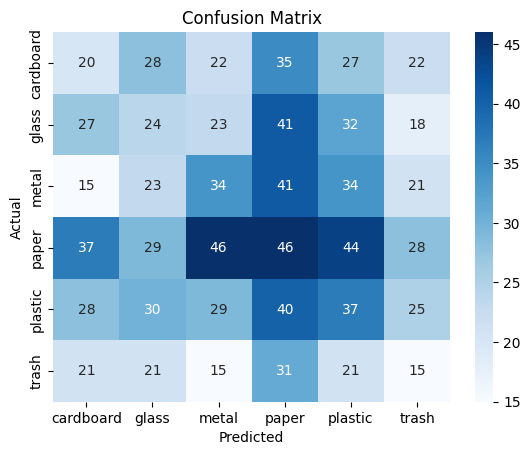

              precision    recall  f1-score   support

   cardboard       0.14      0.13      0.13       154
       glass       0.15      0.15      0.15       165
       metal       0.20      0.20      0.20       168
       paper       0.20      0.20      0.20       230
     plastic       0.19      0.20      0.19       189
       trash       0.12      0.12      0.12       124

    accuracy                           0.17      1030
   macro avg       0.17      0.17      0.17      1030
weighted avg       0.17      0.17      0.17      1030



In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

test_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(test_labels, predicted_labels, target_names=test_generator.class_indices.keys()))


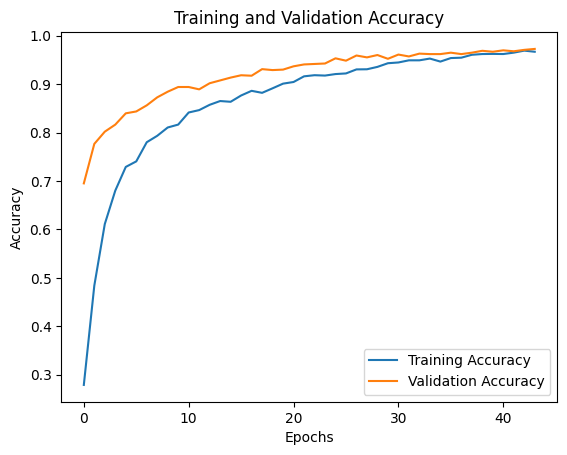

Final Training Accuracy: 96.70%
Final Validation Accuracy: 97.28%


In [21]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Final epoch accuracy
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_training_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%")


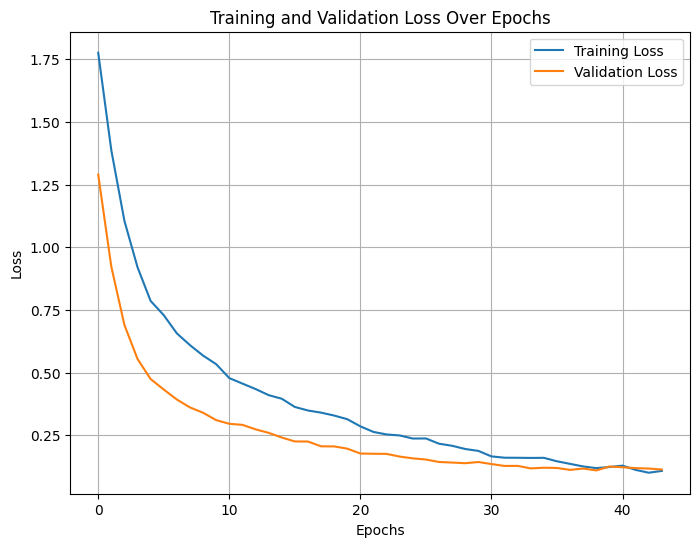

In [22]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
#model.summary()

In [2]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np

In [3]:
model = tf.keras.models.load_model("Restnetv2_model.keras")

In [6]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
# Path to your test dataset
test_dir = "C:/Users/PERCY JACKSON/OneDrive/Desktop/Jupyter Notebook/project/dataset-split/test"

# Image data generator for test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Must match input size of model
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for accurate confusion matrix
)


Found 1030 images belonging to 6 classes.


In [11]:
# Get ground truth labels
y_true = test_generator.classes

# Get predicted probabilities
y_pred_prob = model.predict(test_generator)

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_prob, axis=1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step


              precision    recall  f1-score   support

   cardboard       0.99      0.95      0.97       154
       glass       0.97      0.92      0.94       165
       metal       0.96      0.96      0.96       168
       paper       0.97      0.99      0.98       230
     plastic       0.92      0.95      0.94       189
       trash       0.94      0.98      0.96       124

    accuracy                           0.96      1030
   macro avg       0.96      0.96      0.96      1030
weighted avg       0.96      0.96      0.96      1030



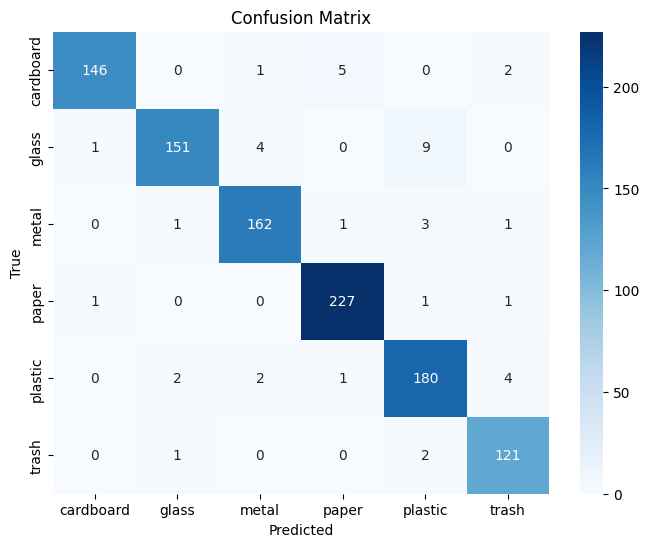

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

# Get class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
